In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import sys
from datetime import datetime
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from scipy import stats
import math

import sys
sys.path.insert(0, 'libraries')
from model_builder import OptimalModel
from hyperopt import hp, STATUS_OK, tpe, atpe, fmin, Trials, SparkTrials, pyll

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [64]:
df_calls = pd.read_csv('../cotton/data/df_cotton_on_call_contracts.csv').rename(columns={'futures_contract':'contract_code'})
df_prices = pd.read_csv('../cotton/data/df_cotton_prices.csv').rename(columns={'a_index':'price'})
df_futures = pd.read_csv('../cotton/data/df_cotton_futures.csv')
df_cotton_futures = df_futures[(df_futures.contract_code.apply(lambda x: x.startswith('CT'))) & (df_futures.contract_code!='CTY00')]
df_spot_price = df_futures[df_futures.contract_code == 'CTY00'].rename(columns={'open':'price'})

In [65]:
df_max_interest = df_cotton_futures.groupby('date').open_interest.max().reset_index()
df_futures_prices = df_cotton_futures.merge(df_max_interest, on=['date', 'open_interest'], how='inner').sort_values('date')
df_futures_prices = df_futures_prices[['date', 'close']].rename(columns={'close':'price'})

<Axes: xlabel='date'>

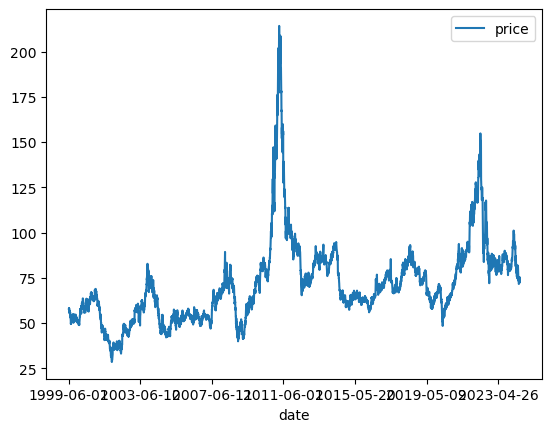

In [107]:
df_futures_prices.sort_values('date').plot(x='date', y='price')

<Axes: xlabel='date'>

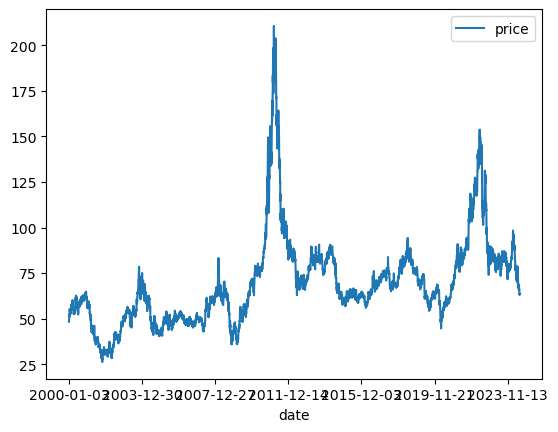

In [108]:
df_spot_price.sort_values('date').plot(x='date', y='price')

<Axes: xlabel='date'>

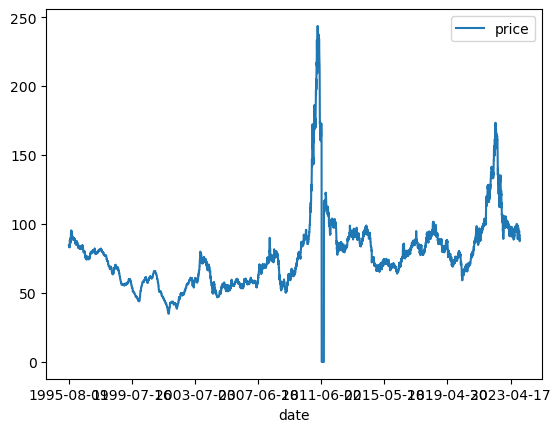

In [109]:
df_prices.plot(x='date', y='price')

In [9]:
def add_cyclical_features(df, datetime_var, period, start_num=0):
    
    values = 2 * np.pi * (df[datetime_var] - start_num) / period
    kwargs = {f'sin_{datetime_var}': lambda x: np.sin(values),
              f'cos_{datetime_var}': lambda x: np.cos(values)}
    
    return df.assign(**kwargs)

In [173]:
class OnCallPrep:
    
    def __init__(self, df_calls):
        
        self.df_calls = df_calls.copy()
        
        self._create_misc_vars()

    def _create_misc_vars(self):
        
        self.df_calls = self.df_calls.rename(columns={'unfixed_purchase': 'purchase', 'unfixed_sale': 'sale'})
        
        self.df_calls['net'] = self.df_calls['sale'] - self.df_calls['purchase']
        self.df_calls['total'] = self.df_calls['sale'] + self.df_calls['purchase']
        # If no sales or purchases, make proportion equal (0.5), avoiding the division by 0
        self.df_calls['prop'] = np.where(self.df_calls['total'] == 0, 0.5, self.df_calls['sale'] / self.df_calls['total'])
        self.df_calls['report_month'] = pd.to_datetime(self.df_calls['date']).dt.month
        self.df_calls['report_year'] = pd.to_datetime(self.df_calls['date']).dt.isocalendar().year
        self.df_calls['futures_datetime'] = pd.to_datetime(self.df_calls['month'])
        self.df_calls['futures_month'] = pd.to_datetime(self.df_calls['month']).dt.month
        self.df_calls['futures_year'] = pd.to_datetime(self.df_calls['month']).dt.isocalendar().year
        self.df_calls['report_year_check'] = self.df_calls['date'].apply(lambda date: int(str(date)[0:4]))
        
        n_mismatches = self.df_calls[self.df_calls['report_year'] != self.df_calls['report_year_check']].shape[0]
        if n_mismatches > 0:
            # Weirdest bug ive ever seen
            print(f'Warning: pd.to_datetime has failed to convert the year properly in {n_mismatches} rows')
            self.df_calls['report_year'] = np.where(self.df_calls['report_year_check'] != self.df_calls['report_year'], self.df_calls['report_year_check'], self.df_calls['report_year'])

        self.df_calls['futures_month_ranked'] = self.df_calls.groupby('date')['futures_datetime'].rank(method='dense')
        
        self.df_calls = self._define_seasons(self.df_calls)
        
    def _define_seasons(self, df):
        
        df['season'] = np.where(df['report_month'] <= 7,
                            np.where(df['futures_month'] < 10,  
                                    np.where(df['report_year'] == df['futures_year'], 'season1',  
                                    np.where(df['report_year'] + 1 == df['futures_year'], 'season2', 
                                    np.where(df['report_year'] + 2 == df['futures_year'], 'season3', 'seasonOTHER'))),
                                np.where(df['report_year'] == df['futures_year'], 'season2', 
                                    np.where(df['report_year'] + 1 == df['futures_year'], 'season3', 'seasonOTHER'))),
                            np.where(df['futures_month'] < 10,  
                                    np.where(df['report_year'] + 1 == df['futures_year'], 'season1',  
                                    np.where(df['report_year'] + 2 == df['futures_year'], 'season2', 
                                    np.where(df['report_year'] + 3 == df['futures_year'], 'season3', 'seasonOTHER'))),
                                np.where(df['report_year'] == df['futures_year'], 'season1', 
                                    np.where(df['report_year'] + 1 == df['futures_year'], 'season2', 
                                    np.where(df['report_year'] + 2 == df['futures_year'], 'season3', 'seasonOTHER'))))) 
        
        assert df[df.season=='seasonOTHER'].shape[0] == 0, 'Seasons incorrectly classified'
                                             
        return df
    
    def _create_call_features(self, df_calls, var):

        df_call_months = df_calls.pivot_table(index=['date', 'report_week', 'report_month'], columns='futures_month_ranked', 
                                              values=var, aggfunc='first').reset_index()
        df_call_months = df_call_months.rename(columns={x: f'{var}_calls_month_' + str(int(x)) for x in df_call_months.columns if x not in ['date', 'report_week', 'report_month']})
        
        features = sorted([x for x in df_call_months.columns if f'{var}_calls_month_' in x])
        
        df_call_months[f'{var}_total_calls'] = df_call_months[features].sum(axis=1)
        df_call_months[f'{var}_sum_next_4_calls'] = df_call_months[features[0:4]].sum(axis=1)
        df_call_months[f'{var}_sum_following_4_calls'] = df_call_months[features[4:8]].sum(axis=1)
               
        df_yearweek_total_calls_s1 = df_calls[df_calls.season=='season1']\
                                          .groupby(['date', 'report_week', 'report_month'])[var].sum()\
                                          .reset_index().rename(columns={var:f'{var}_total_calls_season1'})
        df_yearweek_total_calls_s2 = df_calls[df_calls.season=='season2']\
                                          .groupby(['date', 'report_week', 'report_month'])[var].sum()\
                                          .reset_index().rename(columns={var:f'{var}_total_calls_season2'})
        
        df_features = df_call_months.merge(df_yearweek_total_calls_s1, on=['date', 'report_week', 'report_month'], how='left')\
                                    .merge(df_yearweek_total_calls_s2, on=['date', 'report_week', 'report_month'], how='left')
        
        ignore_cols = ['date', 'report_week', 'report_month']
        ignore_cols = ignore_cols + [x for x in df_features.columns if 'month_7' in x or 'month_8' in x]
        for feat in [col for col in df_features.columns if col not in ignore_cols]:
            for n_weeks in [1, 2, 4, 8, 12, 24, 52]:
                df_features[feat + f'_{n_weeks}weeks_ago'] = df_features[feat].shift(n_weeks)
                df_features[feat + f'_pct_share_{n_weeks}week'] = np.where(df_features[feat + f'_{n_weeks}weeks_ago'] + df_features[feat] == 0, 0.5,
                                                                            df_features[feat] / (df_features[feat + f'_{n_weeks}weeks_ago'] + df_features[feat]))
        
        feat = f'{var}_total_calls'
        for n_years in [3, 5, 10]:
            df_features = self._create_previous_year_comparisons_for_report_week(df_features, feat, n_years)
        
        return df_features
    
    def _create_previous_year_comparisons_for_report_week(self, df, feat, n_years):
        
        execution_string = f"df['{feat}_last{n_years}_total'] = df['{feat}']"
        
        for year in range(1, n_years + 1):
            execution_string += f" + df.groupby('report_week')['{feat}'].shift({year})"
        
        exec(execution_string)
        
        # if total value calculated in string execution above is 0, the share of the current week is 1 / n_years
        # For example, if looking back 5 years, if total is 0 (all years have 0 for the given week) then they all have a proportion of 1 / 5 = 0.2
        if_zero_value = 1 / n_years
        df[f'{feat}_last{n_years}_share'] = np.where(df[f'{feat}_last{n_years}_total'] == 0, 
                                                    if_zero_value, 
                                                    df[feat] / df[f'{feat}_last{n_years}_total'])
        
        return df
        
    def create_features(self):
        
        df_features_sale = self._create_call_features(self.df_calls, 'sale')
        df_features_purchase = self._create_call_features(self.df_calls, 'purchase')
        df_features_net = self._create_call_features(self.df_calls, 'net')
        df_features_net_prop = self._create_call_features(self.df_calls, 'prop')
        
        df_features = df_features_sale.merge(df_features_purchase, on=['date', 'report_week', 'report_month'], how='outer')\
                                      .merge(df_features_net, on=['date', 'report_week', 'report_month'], how='outer')\
                                      .merge(df_features_net_prop, on=['date', 'report_week', 'report_month'], how='outer')
        
        self.df_features = add_cyclical_features(df_features, 'report_week', 52, 1)

    def build_outcomes(self, df_in, var, datetime_var, n_forward_looks = [1, 2, 3, 5, 10]):

        df = df_in[[datetime_var, var]].copy()
        for n in n_forward_looks:
            df[f'max_{n}_forward'] = (df.iloc[::-1]
                    .rolling(n, on=datetime_var, min_periods=0)[var]
                    .max()
                    .iloc[::-1])

            df[f'mean_{n}_forward'] = (df.iloc[::-1]
                    .rolling(n, on=datetime_var, min_periods=0)[var]
                    .mean()
                    .iloc[::-1])

            df[f'value_delta_mean_{n}_forward'] = df[f'mean_{n}_forward'] - df[var]
            df[f'value_delta_max_{n}_forward'] = df[f'max_{n}_forward'] - df[var]

            df[f'pct_delta_mean_{n}_forward'] = (df[f'mean_{n}_forward'] / df[var]) - 1
            df[f'pct_delta_max_{n}_forward'] = (df[f'max_{n}_forward'] / df[var]) - 1   

            df[f'binary_mean_rise_{n}_forward'] = np.where(df[f'pct_delta_mean_{n}_forward'] > 0, 1, 0)
            df[f'binary_max_rise_{n}_forward'] = np.where(df[f'pct_delta_max_{n}_forward'] > 0, 1, 0)

            # These values are highly correlated with calls variables, because they are higly correlted with the price at the given time.
            # The high correlation, along with price itself, only tells us that there are many unfixed purchases when prices are low and
            # fewer when prices are high. If we were to use the on-call variables which correlate highly with these, we would just be learning 
            # that when there are high unfixed calls, the price is likely to be low, rather than learning whther the price is likely to
            # increase from here
            df = df.drop(columns=[f'max_{n}_forward', f'mean_{n}_forward'])

        return df.drop(columns=var)
    
    def merge_outcomes(self, df_prices, n_forward_looks):
        
        self.df_outcomes = self.build_outcomes(df_prices, var='price', datetime_var='date', n_forward_looks=n_forward_looks)
        
        shape = self.df_features.shape[0]
        self.df_mset = self.df_features.merge(self.df_outcomes, on='date', how='inner')
        if self.df_mset.shape[0] < shape:
            print(f'Warning: Dropped {shape - self.df_mset.shape[0]} rows where outcome is not available')
        
    def upload(self, filepath):
        
        self.df_mset.to_csv(filepath, index=False)

In [174]:
prep = OnCallPrep(df_calls)
prep.create_features()
prep.merge_outcomes(df_futures_prices, n_forward_looks=[30, 60])
prep.upload('../cotton/data/df_on_call_modelset.csv')
df_mset = prep.df_mset.copy()

In [176]:
df_mset.isnull().sum().sort_values()

date                                   0
net_sum_following_4_calls              0
net_sum_next_4_calls                   0
net_total_calls                        0
net_calls_month_7                      0
                                    ... 
net_total_calls_last10_share         498
sale_total_calls_last10_total        498
purchase_total_calls_last10_total    498
purchase_total_calls_last10_share    498
net_total_calls_last10_total         498
Length: 709, dtype: int64

In [13]:
# remember to sort out prop variables in terms of summing up, we need to average instead for the total calls

In [15]:
# cols = ['date', 'prop_calls_month_1', 'prop_calls_month_2', 'prop_calls_month_3', 'prop_calls_month_4',
#         'prop_calls_month_5', 'prop_calls_month_6', 'prop_calls_month_7', 'prop_calls_month_8',
#         'prop_total_calls', 'prop_total_calls_season1_pct_share_12week']
# df_mset[df_mset.prop_total_calls_season1_pct_share_12week.isnull()][cols]

In [16]:
# df_mset = df_mset[df_mset['binary_mean_rise_30_forward'].notnull()]

In [ ]:
# df_mset.isnull().sum().sort_values().reset_index().loc[100:]

In [177]:
outcome_vars = [x for x in prep.df_outcomes if x not in ['date', 'price']]
correlation_vars = [x for x in df_mset.columns if x not in ['date', 'report_month']]
feat_vars = [x for x in correlation_vars if x not in outcome_vars]
df_corr = df_mset[correlation_vars].corr()
df_corr = df_corr.drop(outcome_vars, axis=0)[outcome_vars].sort_values('value_delta_mean_30_forward')
df_corr.style.background_gradient(cmap='coolwarm')

In [26]:
space_lgb = {
    'n_estimators': pyll.scope.int(hp.quniform('n_estimators', 5, 150, 5)),
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart', 'goss']),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'max_depth': pyll.scope.int(hp.quniform('max_depth', 2, 16, 1)),
    # 'num_leaves': pyll.scope.int(hp.quniform('num_leaves', 2, 150, 1)),
    'min_child_samples': pyll.scope.int(hp.choice('min_child_samples', [3, 5, 10, 20, 30, 40, 50, 60, 70, 80])),
    'reg_alpha': hp.choice('reg_alpha', [0, 0.001, 0.01, 0.1, 0.2]),
    'reg_lambda': hp.choice('reg_lambda', [0, 0.001, 0.01, 0.1, 0.2]),
    # 'cutoff': hp.quniform('cutoff', 0.01, 1, 0.01),
    # 'outcome_var': hp.choice('outcome_var', vars)
#     'feature_fraction': hp.uniform('feature_fraction', 0.1, 1.0),
#     'subsample': hp.uniform('subsample', 0.1, 1.0),
#     'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    #,'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0)
}

space_logistic_regularised = {
  'penalty':hp.choice('penalty', ['l1']),
  'solver':hp.choice('solver', ['saga', 'liblinear']),  
  'C': hp.quniform('C', 0.01, 1, 0.01),
  'cutoff': hp.quniform('cutoff', 0.01, 1, 0.01)
}

space_lasso = {
  'alpha': hp.uniform('alpha', 0, 1),
  'max_iter': hp.choice('max_iter', [100000]) 
}

df = df_mset[df_mset.report_month == 2].copy()

print(df.shape)
df = df[feat_vars + ['value_delta_mean_30_forward']].dropna()
print(df.shape)

opt = OptimalModel(df_train=df,
                   df_test=df,
                   cols=feat_vars, 
                   outcome_var='value_delta_mean_30_forward',
                   model_type='lgb', 
                   evals=20, 
                   opt_lib='hp', 
                   search_space=space_lgb, 
                   how_to_tune='cross_val', 
                   eval_metric='explained_variance',
                   n_jobs=-1, 
                   seed=123, 
                   outcome_type='regression', 
                   k=2,
                   stratify_kfold=False)

model, params, trials, importance, errors, cv_scores = opt.build_optimal_model()

(93, 567)
(83, 560)
Performing model optimisation
100%|███████████| 20/20 [00:04<00:00,  4.68trial/s, best loss: 4.12932061558111]
20 rounds of hp cross_val optimisation ran in 4.28 seconds
LGB built in 0.291 seconds
Train error: 3.517511764669245
Test error: 3.517511764669245
Train explained variance: 0.3567320636108555
Test explained variance: 0.3567320636108555
Train WAPE: 2.8012866173497026
Test WAPE: 2.8012866173497026
Best parameters found: {'boosting_type': 'dart', 'learning_rate': 0.020279819042128208, 'max_depth': 4, 'min_child_samples': 20, 'n_estimators': 145, 'reg_alpha': 0.1, 'reg_lambda': 0.01}
Cross validation scores: [-25.53688521 -10.27355001]


In [27]:
importance

feature          gain  splits  prop_gain  \
0           prop_sum_next_4_calls_4weeks_ago  10117.530975      54   0.285948   
1              prop_calls_month_2_2weeks_ago   9486.771191      52   0.268122   
2          prop_sum_next_4_calls_12weeks_ago   2266.631989      15   0.064061   
3             prop_calls_month_6_52weeks_ago   2064.808098      33   0.058357   
4               net_calls_month_1_4weeks_ago   1806.900017      12   0.051068   
..                                       ...           ...     ...        ...   
554   purchase_calls_month_3_pct_share_1week      0.000000       0   0.000000   
555        purchase_calls_month_3_1weeks_ago      0.000000       0   0.000000   
556  purchase_calls_month_2_pct_share_52week      0.000000       0   0.000000   
557       purchase_calls_month_2_52weeks_ago      0.000000       0   0.000000   
558                          cos_report_week      0.000000       0   0.000000   

     prop_splits  rank_splits  rank_gain  
0       0.174194          1.0        1.0  
1       0.167742          2.0        2.0  
2       0.048387          6.0        3.0  
3       0.106452          3.0        4.0  
4       0.038710          7.0        5.0  
..           ...          ...        ...  
554     0.000000        293.0      293.0  
555     0.000000        293.0      293.0  
556     0.000000        293.0      293.0  
557     0.000000        293.0      293.0  
558     0.000000        293.0      293.0  

[559 rows x 7 columns]

<Axes: xlabel='purchase_sum_next_4_calls_pct_share_12week', ylabel='value_delta_mean_30_forward'>

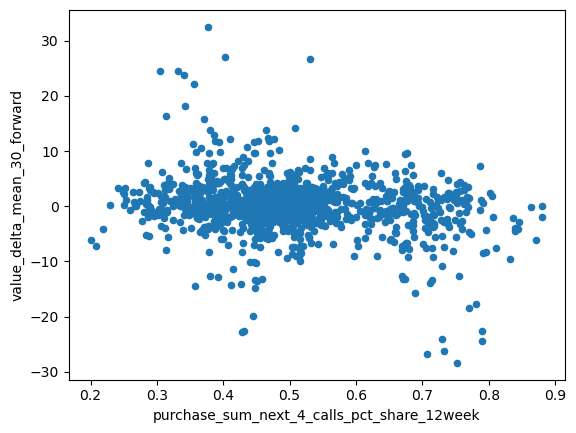

In [74]:
df_mset.plot(kind='scatter', x='purchase_sum_next_4_calls_pct_share_12week', y='value_delta_mean_30_forward')

In [90]:
var = 'unfixed_purchase_calls_month_2_pct_change_4week'
df_stat = df_mset[(df_mset[var].notnull())]
stats.pointbiserialr(df_stat[var], df_stat['binary_mean_rise_30_forward'])

SignificanceResult(statistic=0.07216328872860983, pvalue=0.016875020186839736)

In [221]:
df_corr_top

index  value_delta_mean_30_forward
0  unfixed_purchase_total_calls_season1                    -0.461605
1        unfixed_purchase_calls_month_2                    -0.399632
2          unfixed_purchase_total_calls                    -0.270182
3  unfixed_net_prop_total_calls_season1                     0.508085
4        unfixed_net_prop_calls_month_2                     0.529571
5        unfixed_net_prop_calls_month_4                     0.613371

In [304]:
# class Correlations:
    
#     def monthly_correlations(self, df_mset, outcome):
        
#         correlations = []

#         for month in df_mset['report_month'].unique():
#             df_corr = self.get_month_correlations(month, outcome)
#             correlations.append(df_corr)
            
#         df_monthly_corrs = pd.concat(correlations)
        
#         return df_monthly_corrs
            
#     def get_month_correlations(df_mset, month, outcome, top_n=5):
            
#         df = df_mset[df_mset['report_month'] == month]
#         df_corr = df[correlation_vars].corr()
#         df_corr = df_corr.drop(outcome_vars, axis=0)[outcome_vars].sort_values(outcome)
#         df_corr_top = pd.concat([df_corr[[outcome]].iloc[0:top_n], df_corr[[outcome]].iloc[-top_n:]], axis=0)\
#                         .reset_index().rename(columns={'index':'feat'})
#         for i, row in df_corr_top.iterrows():
#             feat = row['feat']
#             null_prop = df[df[feat].isnull()].shape[0] / df.shape[0]
#             df_corr_top.loc[i, 'null_prop'] = null_prop
#         df_corr_top['report_month'] = month
        
#         return df_corr_top, df
    
#     def plot(df_mset, month, outcome, top_n=6, n_per_row=3, figsize=(15, 7)):
        
#         df_corr, df_month = Correlations.get_month_correlations(df_mset, month, outcome, top_n=top_n)
        
#         n_rows = math.ceil(top_n / n_per_row)
#         _, axs = plt.subplots(n_rows, n_per_row, figsize=figsize)
        
#         for feat, ax in zip(df_corr['feat'].values, axs.flatten()):
#             ax.plot(x=df_month['feat'], y=df_month[outcome], kind='scatter') 
#             ax.set_title(feat + ' month ' + str(month))  
            
            
# outcome = 'value_delta_mean_30_forward'            
# Correlations.plot(df_mset[feat_vars + [outcome]], 1, outcome, top_n=6, n_per_row=3, figsize=(15, 7))

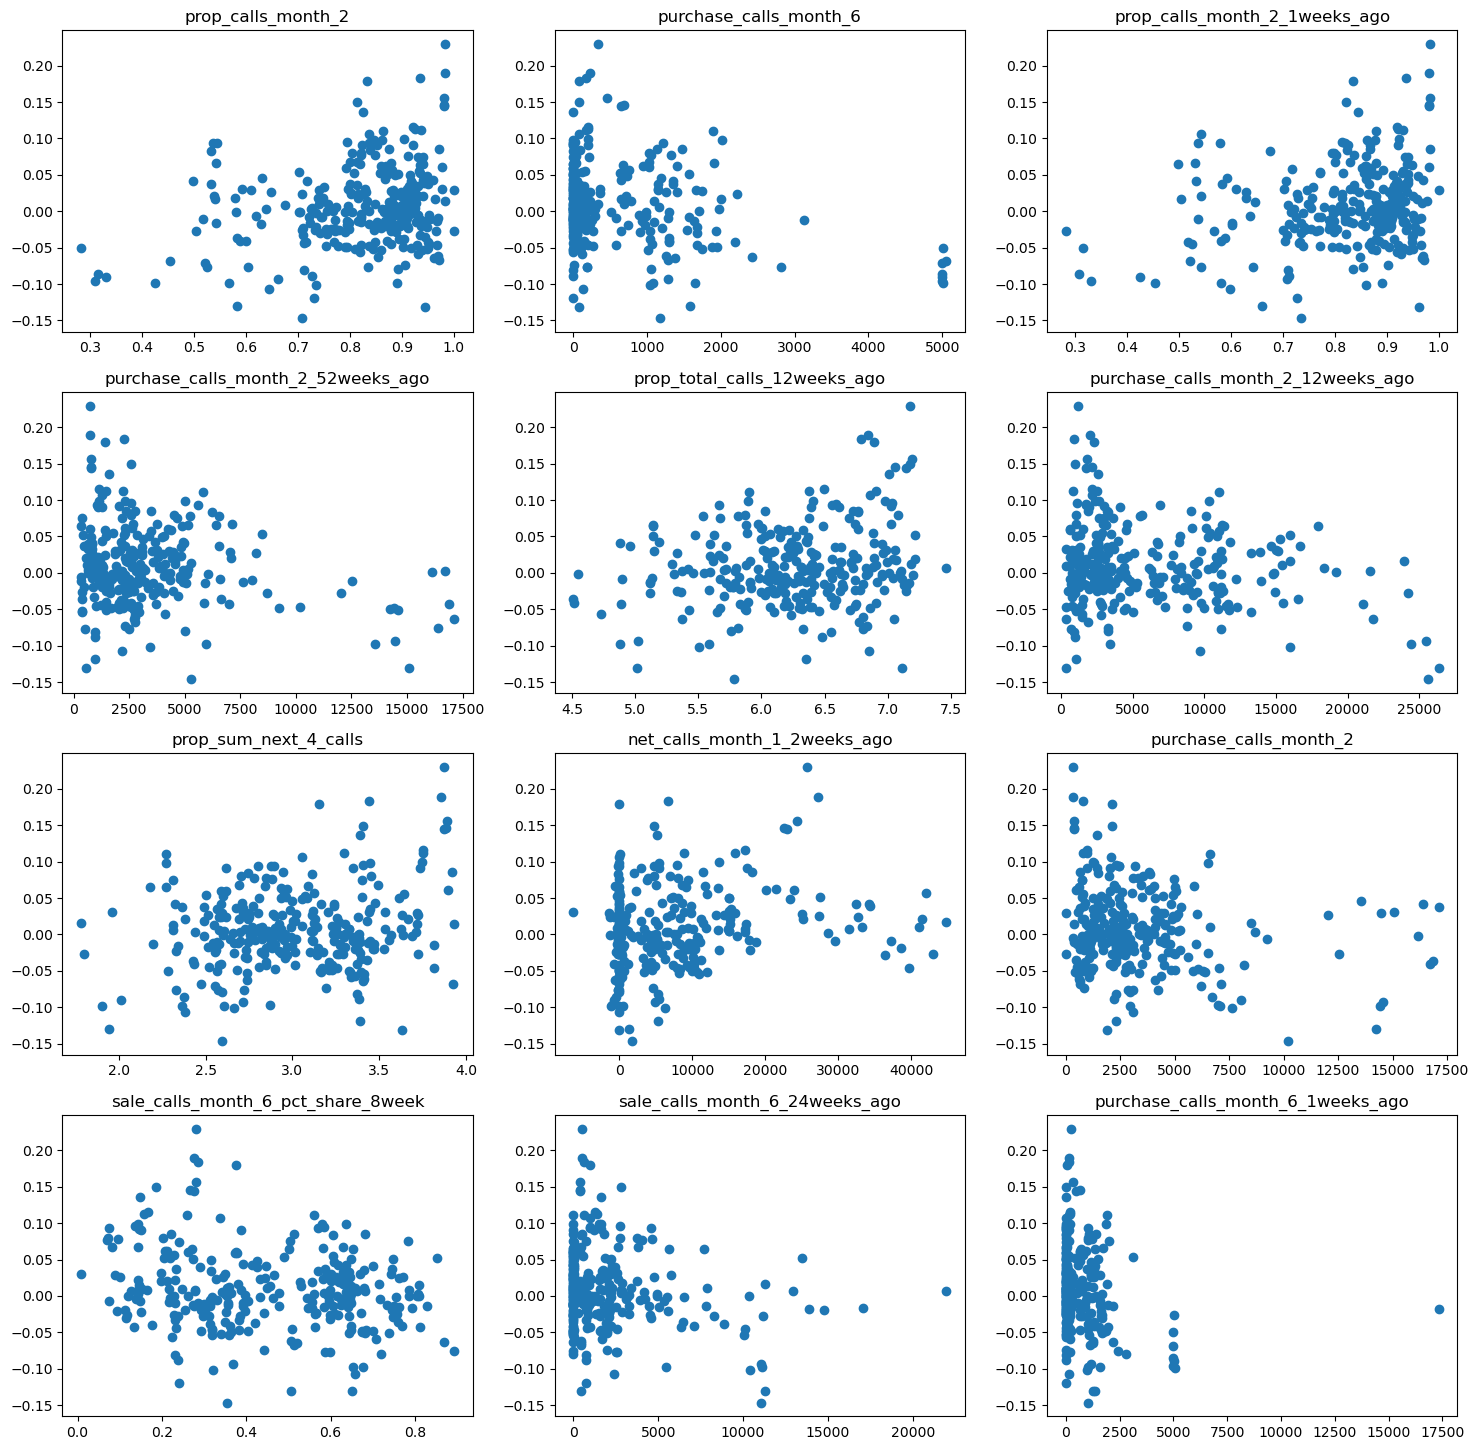

In [76]:
class Correlations:
    
    def __init__(self, df_mset, feat_vars, outcome):
        
        self.df_mset = df_mset
        self.feat_vars = feat_vars
        self.outcome = outcome
        
        # outcome_vars = [x for x in prep.df_outcomes if x not in ['date', 'price']]
        # correlation_vars = [x for x in df_mset.columns if x not in ['date', 'report_month']]
        # feat_vars = [x for x in correlation_vars if x not in outcome_vars]
        
        self.correlation_vars = feat_vars + [outcome]
        
        self.df_corr = self.df_mset[self.correlation_vars].corr()
        self.df_corr = self.df_corr.drop([self.outcome], axis=0)[[self.outcome]].sort_values(self.outcome)
        self.df_corr.style.background_gradient(cmap='coolwarm')
    
    def monthly_correlations(self):
        
        correlations = []

        for month in self.df_mset['report_month'].unique():
            df_corr = self.get_month_correlations(month, outcome)
            correlations.append(df_corr)
            
        self.df_monthly_corrs = pd.concat(correlations)
            
    def get_month_correlations(self, month, top_n=5):
        
        if isinstance(month, list):
            df = self.df_mset[self.df_mset['report_month'].isin(month)]
        else:
            df = self.df_mset[self.df_mset['report_month'] == month]
        
        df_corr = df[self.correlation_vars].corr()
        df_corr = df_corr.drop(self.outcome, axis=0)[self.outcome]\
                         .reset_index().rename(columns={'index':'feat'})
        
        df_corr['abs_corr'] = abs(df_corr[self.outcome])
        df_corr = df_corr.sort_values('abs_corr', ascending=False)
        df_corr_top = df_corr.iloc[0:top_n].copy()
        
        # df_corr_top = pd.concat([df_corr[[self.outcome_vars]].iloc[0:top_n], df_corr[[outcome]].iloc[-top_n:]], axis=0)\
        #                 .reset_index().rename(columns={'index':'feat'})
        for i, row in df_corr_top.iterrows():
            feat = row['feat']
            null_prop = df[df[feat].isnull()].shape[0] / df.shape[0]
            df_corr_top.loc[i, 'null_prop'] = null_prop
        # df_corr_top['report_month'] = month
        
        # df_corr_low_nulls = df_corr[df_corr.null_prop >= min_null_prop].copy()
        # df_corr_low_nulls = df_corr_low_nulls.sort_values('abs_corr', ascending=False).reset_index()
        # df_corr_top = df_corr_low_nulls.iloc[0:top_n].copy()
        
        return df_corr_top, df
    
    def plot_correlations(self, month, top_n=6, n_per_row=3, figsize=(15, 7)):
        
        df_corr, df_month = self.get_month_correlations(month, top_n=top_n)
        
        n_rows = math.ceil(top_n / n_per_row)
        _, axs = plt.subplots(n_rows, n_per_row, figsize=figsize)
        
        for feat, ax in zip(df_corr['feat'].values, axs.flatten()):
            ax.scatter(df_month[feat], df_month[self.outcome]) 
            ax.set_title(feat)             
             
                                   
corr = Correlations(df_mset, feat_vars, 'pct_delta_mean_30_forward')
corr.plot_correlations([1, 2, 3], top_n=12, figsize=(18, 18))                         
            
#     binary_significances = []           
#     for var in feat_vars:
#         df_stat = df[(df[var].notnull())]
#         if df_stat[var].isnull().sum() > 0:
#             print(month, ' ', var)
#         result = stats.pointbiserialr(df_stat[var], df_stat['binary_mean_rise_30_forward'])
#         df_sign = pd.DataFrame({'month':month, 'feature':var, 'corr':result.statistic, 'pvalue':result.pvalue}, index=[0])
#         binary_significances.append(df_sign)

# df_binary = pd.concat(binary_significances).reset_index(drop=True)

In [86]:
corr = Correlations(df_mset, feat_vars, 'value_delta_mean_30_forward')
df_corr, df_month = corr.get_month_correlations(1, top_n=24)

df_corr

feat  \
53                 sale_calls_month_3_pct_share_52week   
109                  sale_total_calls_pct_share_52week   
123             sale_sum_next_4_calls_pct_share_52week   
39                 sale_calls_month_2_pct_share_52week   
331                 net_calls_month_3_pct_share_52week   
164            purchase_calls_month_1_pct_share_52week   
317                 net_calls_month_2_pct_share_52week   
401              net_sum_next_4_calls_pct_share_52week   
387                   net_total_calls_pct_share_52week   
338                       net_calls_month_4_8weeks_ago   
60                       sale_calls_month_4_8weeks_ago   
320                       net_calls_month_3_2weeks_ago   
278  purchase_sum_following_4_calls_pct_share_last_...   
42                       sale_calls_month_3_2weeks_ago   
281                                  net_calls_month_3   
318                       net_calls_month_3_1weeks_ago   
449                      prop_calls_month_2_8weeks_ago   
40                       sale_calls_month_3_1weeks_ago   
3                                   sale_calls_month_3   
340                      net_calls_month_4_12weeks_ago   
429                      prop_calls_month_1_1weeks_ago   
326                      net_calls_month_3_12weeks_ago   
535                  prop_sum_next_4_calls_12weeks_ago   
431                      prop_calls_month_1_2weeks_ago   

     value_delta_mean_30_forward  abs_corr  null_prop  
53                      0.566462  0.566462   0.041667  
109                     0.514805  0.514805   0.041667  
123                     0.494532  0.494532   0.041667  
39                      0.490518  0.490518   0.041667  
331                     0.465813  0.465813   0.041667  
164                    -0.451725  0.451725   0.041667  
317                     0.447671  0.447671   0.041667  
401                     0.434925  0.434925   0.041667  
387                     0.377710  0.377710   0.041667  
338                     0.363682  0.363682   0.000000  
60                      0.355062  0.355062   0.000000  
320                     0.350814  0.350814   0.000000  
278                     0.349726  0.349726   0.093750  
42                      0.347728  0.347728   0.000000  
281                     0.347306  0.347306   0.000000  
318                     0.345713  0.345713   0.000000  
449                     0.342534  0.342534   0.000000  
40                      0.340115  0.340115   0.000000  
3                       0.337362  0.337362   0.000000  
340                     0.336978  0.336978   0.000000  
429                     0.336831  0.336831   0.000000  
326                     0.326213  0.326213   0.000000  
535                     0.325312  0.325312   0.000000  
431                     0.323426  0.323426   0.000000

Explained variance: 0.366359772828868


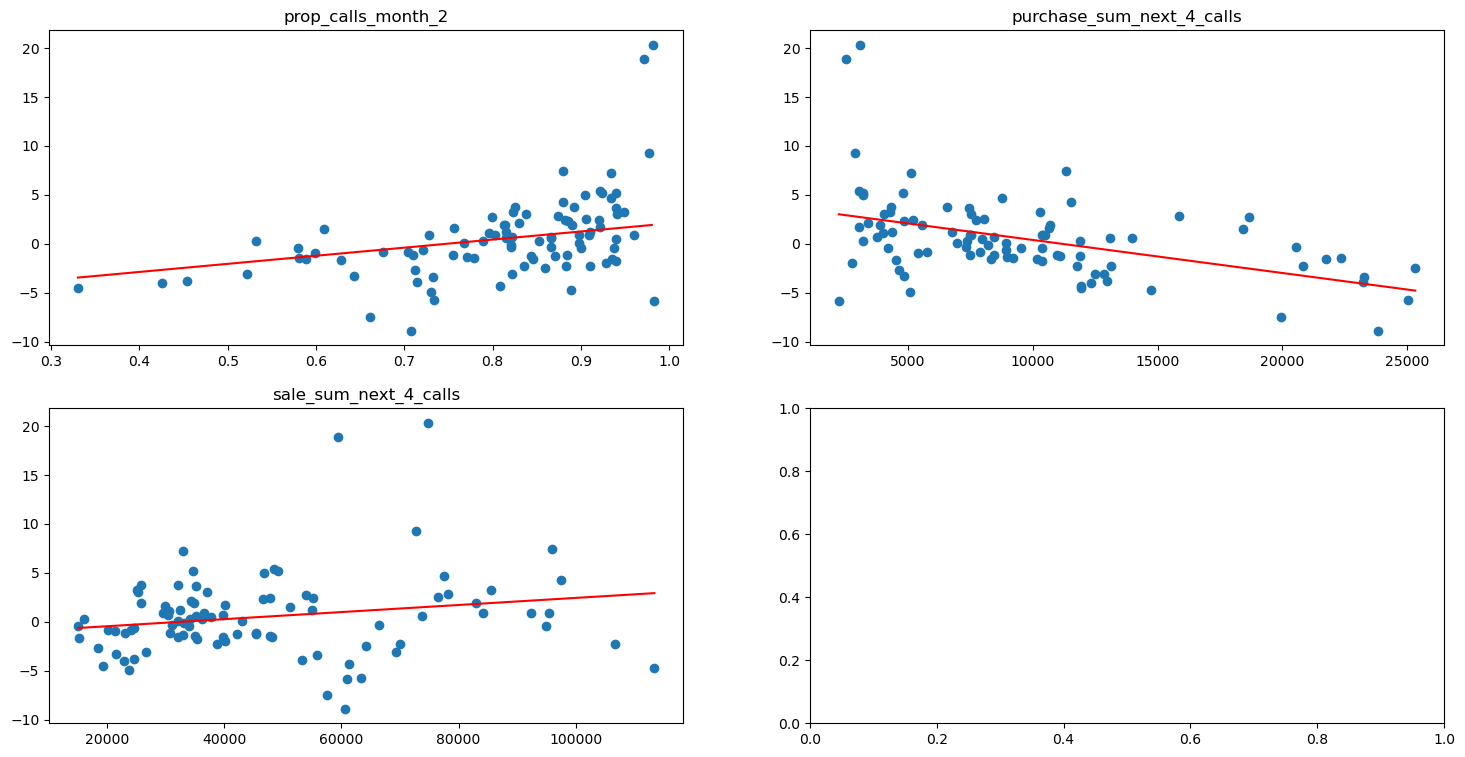

In [168]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, mean_squared_error, explained_variance_score

class LinearRegressionModel():
    
    def __init__(self, df, month=None):
        
        self.df = df
        self.month = month
        
        if self.month is not None:
            self.df = self.df[self.df['report_month'] == self.month].copy()
    
    def data_prep(self, df, features, outcome):

        df = df[features + [outcome]].dropna()
        
        return df
    #     if len(feat) > 1:

    #     else:
    #         n_missing = df[feat].isnull().sum().sum()
    #         if n_missing > 0:
    #             print(f'Warning: dropping {n_missing} missing values from feature')
    #             df = df[df[feat].notnull()].copy()

    #     n_y_missing = df[outcome].isnull().sum()
    #     if n_y_missing > 0:
    #         print(f'Warning: dropping {n_y_missing} missing values from outcome')
    #         df = df[df[outcome].notnull()].copy()
    
    def fit(self, features, outcome):
        
        if isinstance(features, str):
            features = [features]
            
        self.features = features
        self.outcome = outcome
        
        self.df = self.data_prep(self.df, features, outcome)
        
        self.model = LinearRegression()
        self.model.fit(self.df[features], self.df[outcome])

        self.df['pred'] = self.model.predict(self.df[features])

        self.explained_variance = explained_variance_score(self.df[outcome], self.model.predict(self.df[features]))
        
        print(f'Explained variance: {self.explained_variance}')
    
    def plot(self, n_per_row=2, figsize=(18, 9)):
        
        n_feats = len(self.features)
        n_rows = math.ceil(n_feats / n_per_row)

        _, axs = plt.subplots(n_rows, n_per_row, figsize=figsize)

        if n_feats > 1:
            axes = axs.flatten()
        else:
            axes = axs

        for feat, ax in zip(self.features, axes):

            other_features = [x for x in self.features if x != feat]
            df_preds = pd.DataFrame({feat:np.arange(self.df[feat].min(), self.df[feat].max(), 0.01)})

            for constant_feat in other_features:
                df_preds[constant_feat] = self.df[constant_feat].mean()

            df_preds['pred'] = self.model.predict(df_preds[self.features])

            ax.scatter(self.df[feat], self.df[self.outcome])
            ax.plot(df_preds[feat], df_preds['pred'], c='red')
            ax.set_title(f'{feat}')

model = LinearRegressionModel(df_mset, 2)
model.fit(features=['prop_calls_month_2', 
                    'purchase_sum_next_4_calls', 
                    'sale_sum_next_4_calls'], 
          outcome='value_delta_mean_30_forward')
model.plot()

Explained variance: 0.38663091360973034


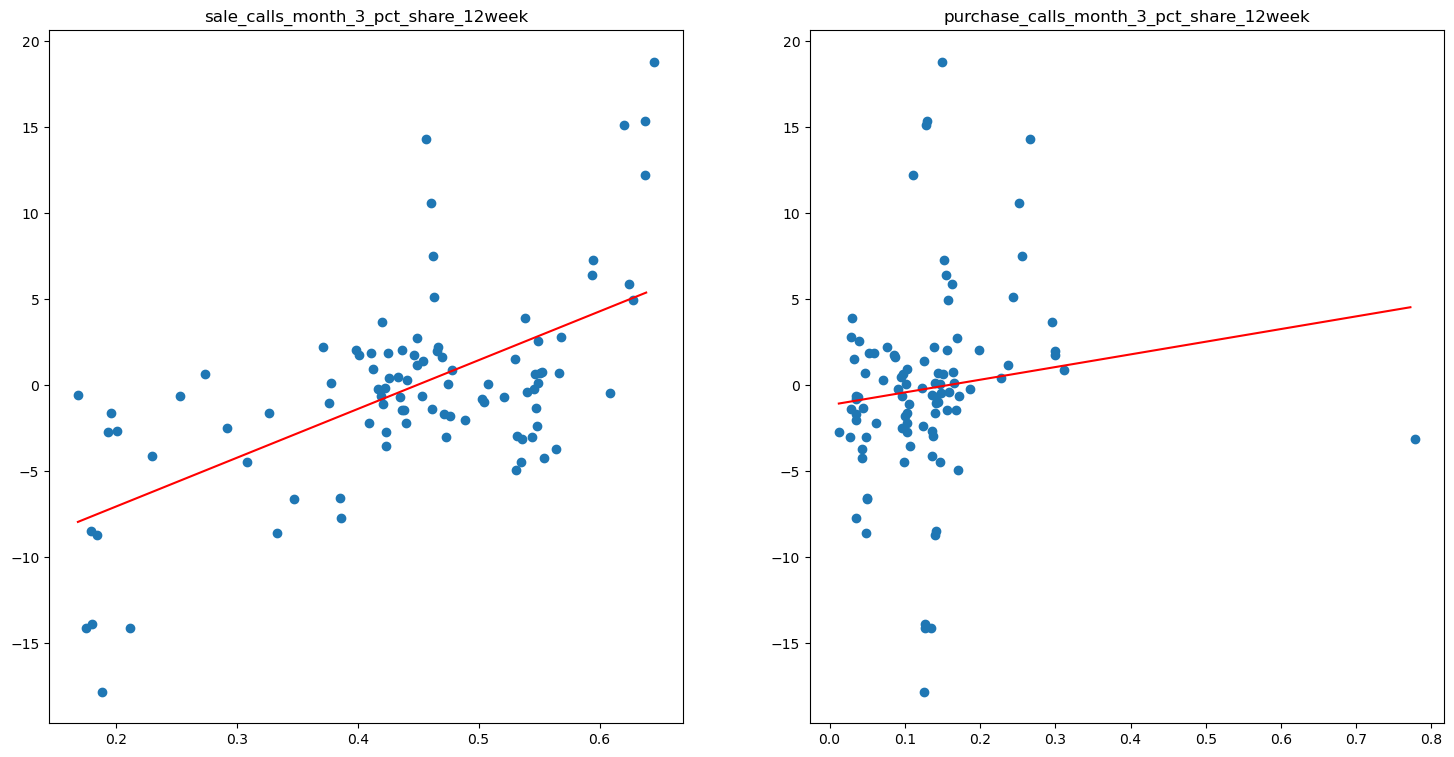

In [169]:
model = LinearRegressionModel(df_mset, 9)
model.fit(features=['sale_calls_month_3_pct_share_12week', 'purchase_calls_month_3_pct_share_12week'], 
          outcome='value_delta_mean_30_forward')
model.plot()

Explained variance: 0.05799474080889211


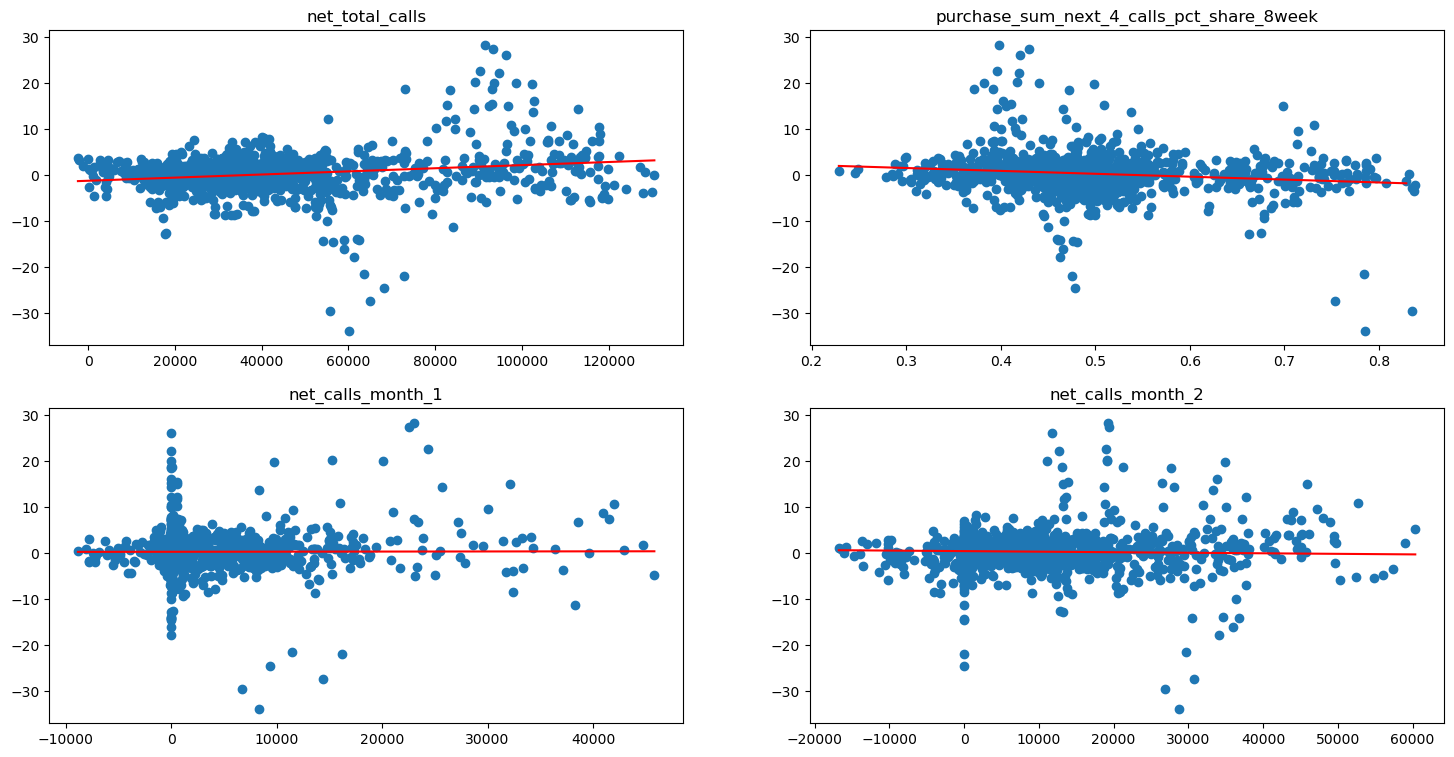

In [175]:
model = LinearRegressionModel(df_mset)
model.fit(features=['net_total_calls', 'purchase_sum_next_4_calls_pct_share_8week', 'net_calls_month_1', 'net_calls_month_2'], 
          outcome='value_delta_mean_30_forward')
model.plot()

In [378]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, mean_squared_error, explained_variance_score

def univariate_model(df, month, features, outcome, n_per_row=2, figsize=(18, 9)):
    
    df = df_mset[df_mset.report_month == month].copy()
    
    if isinstance(features, str):
        features = [features]
        
    df = df[features + [outcome]].dropna()
#     if len(feat) > 1:
        
#     else:
#         n_missing = df[feat].isnull().sum().sum()
#         if n_missing > 0:
#             print(f'Warning: dropping {n_missing} missing values from feature')
#             df = df[df[feat].notnull()].copy()
    
#     n_y_missing = df[outcome].isnull().sum()
#     if n_y_missing > 0:
#         print(f'Warning: dropping {n_y_missing} missing values from outcome')
#         df = df[df[outcome].notnull()].copy()
        
    model = LinearRegression()
    model.fit(df[features], df[outcome])

    df['pred'] = model.predict(df[features])

    explained_variance = explained_variance_score(df[outcome], model.predict(df[features]))
    
    n_feats = len(features)
    n_rows = math.ceil(n_feats / n_per_row)
    
    _, axs = plt.subplots(n_rows, n_per_row, figsize=figsize)
    
    if n_feats > 1:
        axes = axs.flatten()
    else:
        axes = [axs]
        
    for feat, ax in zip(features, axes):
        
        other_features = [x for x in features if x != feat]
        df_preds = pd.DataFrame({feat:np.arange(df[feat].min(), df[feat].max(), 0.01)})
        
        for constant_feat in other_features:
            df_preds[constant_feat] = df[constant_feat].mean()
        
        df_preds['pred'] = model.predict(df_preds[features])

        ax.scatter(df[feat], df[outcome])
        ax.plot(df_preds[feat], df_preds['pred'], c='red')
        ax.set_title(f'{feat}, Explained Variance: {np.round(explained_variance, 2)}')

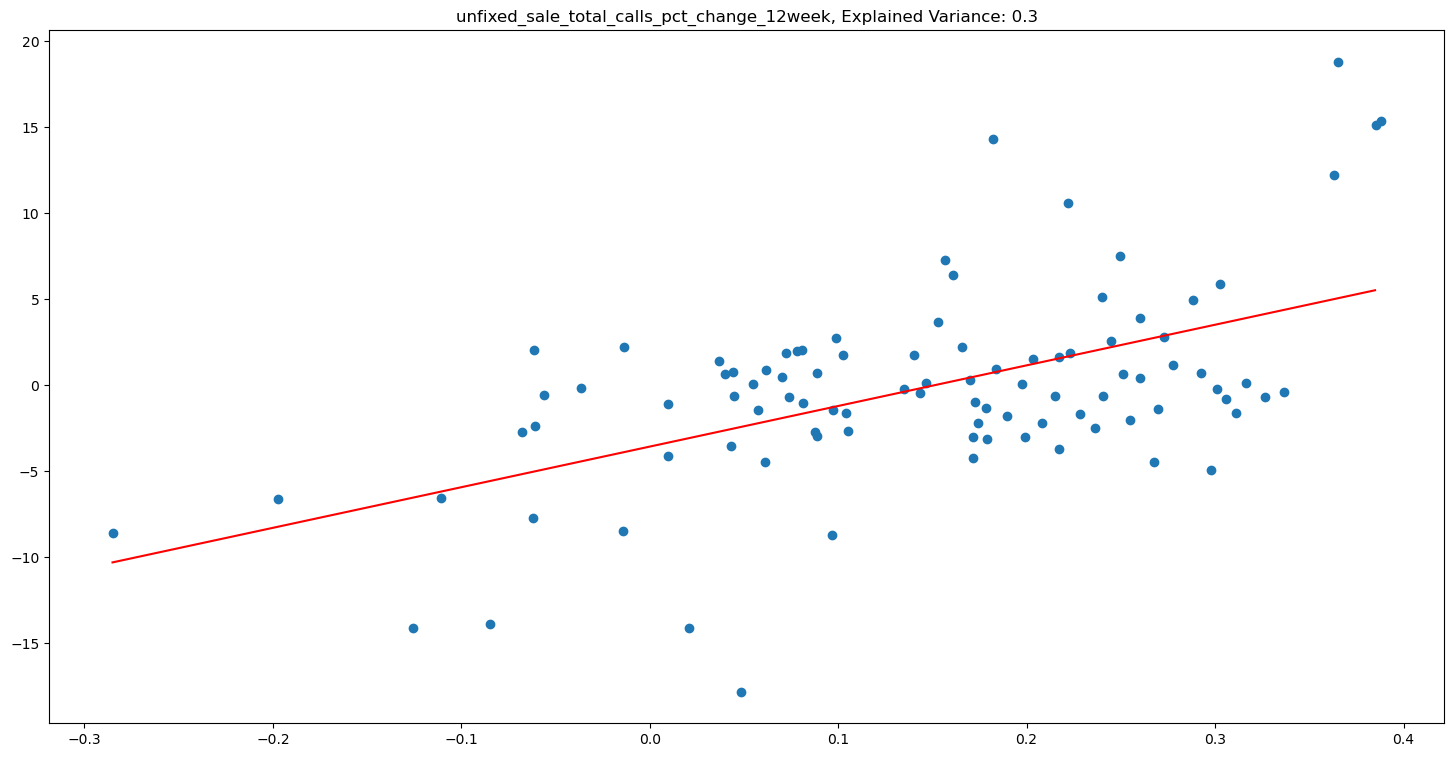

In [368]:
univariate_model(df, 9, features='unfixed_sale_total_calls_pct_change_12week', outcome='value_delta_mean_30_forward')

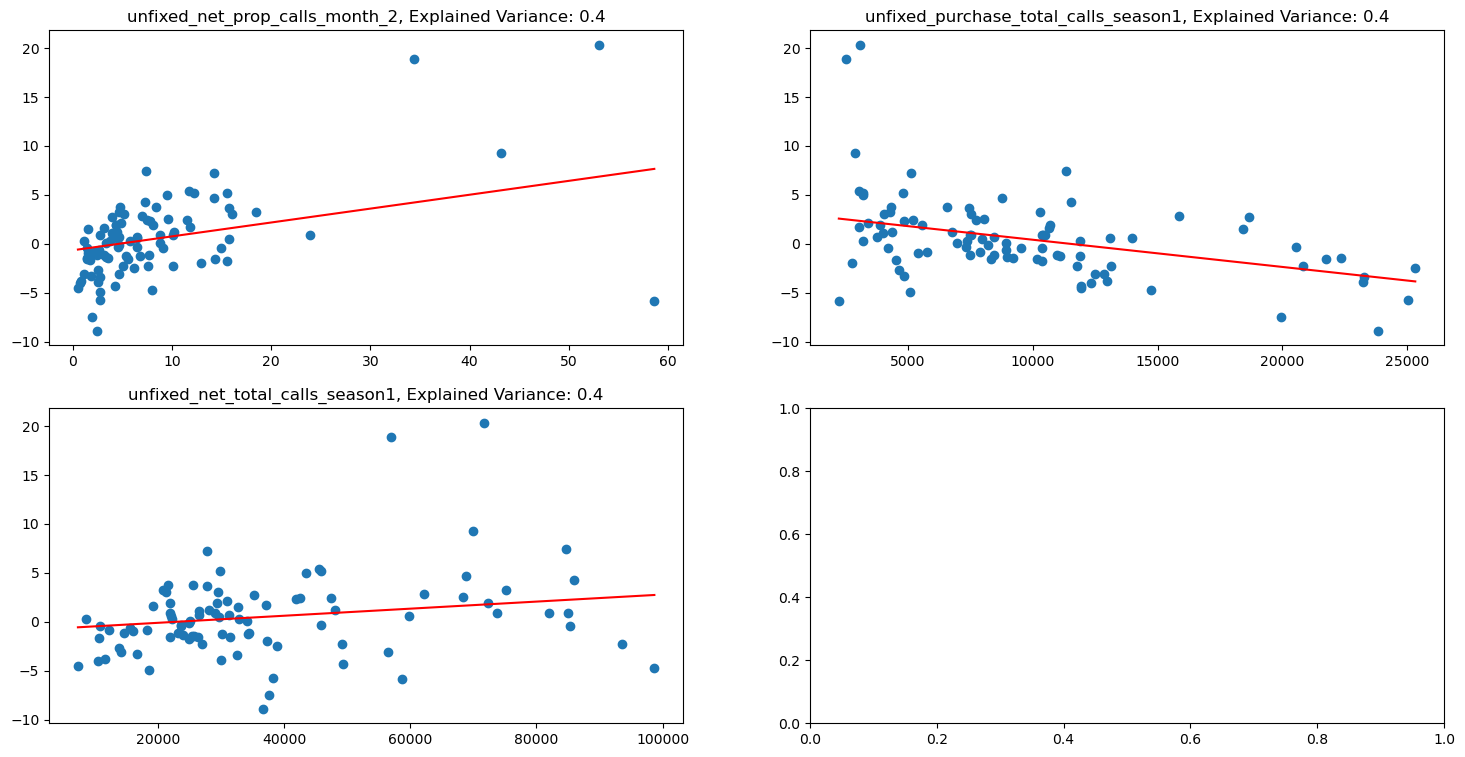

In [379]:
univariate_model(df, 2, 
                 features=['unfixed_net_prop_calls_month_2', 'unfixed_purchase_total_calls_season1', 'unfixed_net_total_calls_season1'], 
                 outcome='value_delta_mean_30_forward')

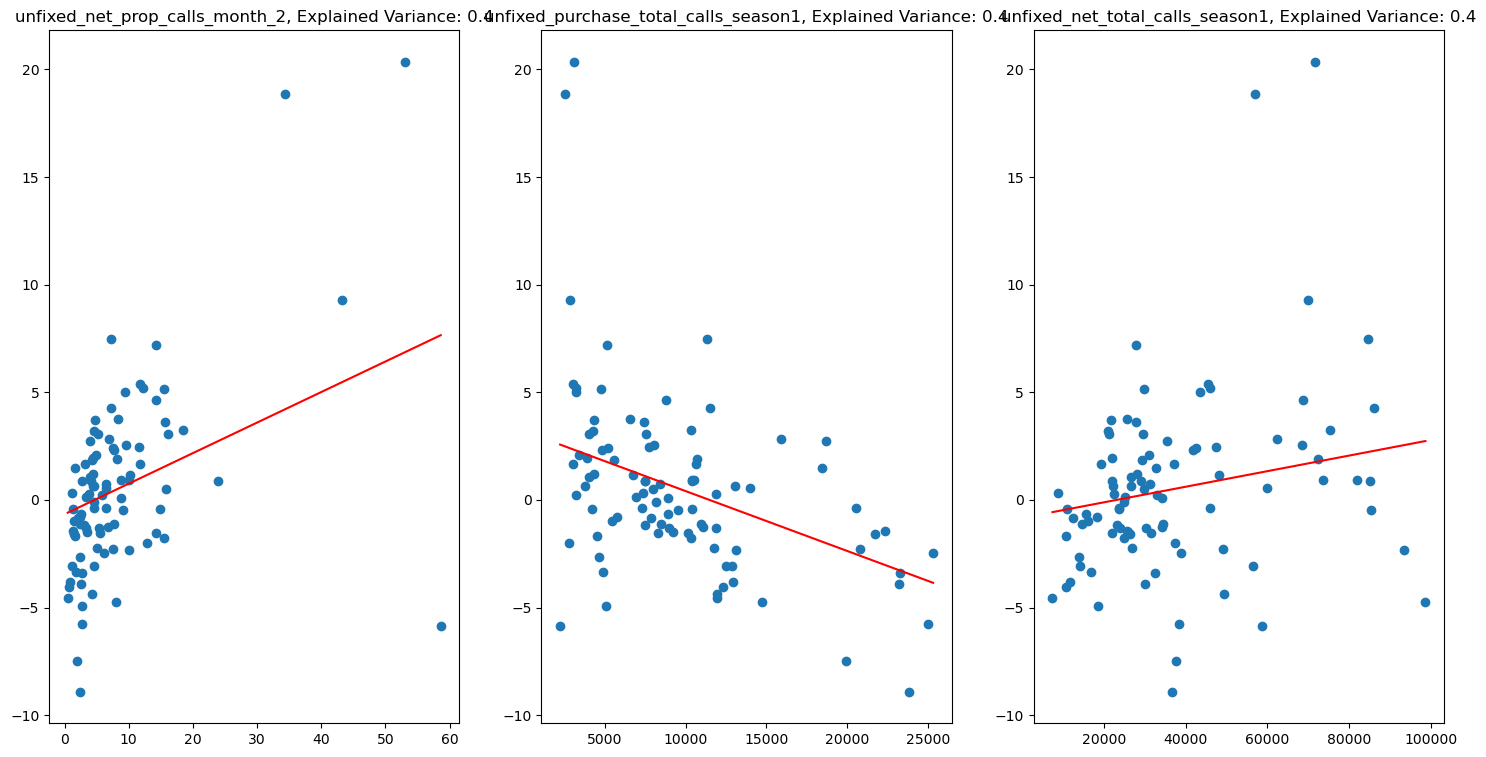

In [357]:
univariate_model(df, 2, 
                 features=['unfixed_net_prop_calls_month_2', 'unfixed_purchase_total_calls_season1', 'unfixed_net_total_calls_season1'], 
                 outcome='value_delta_mean_30_forward')

array([[<Axes: title={'center': 'value_delta_mean_30_forward'}>]],
      dtype=object)

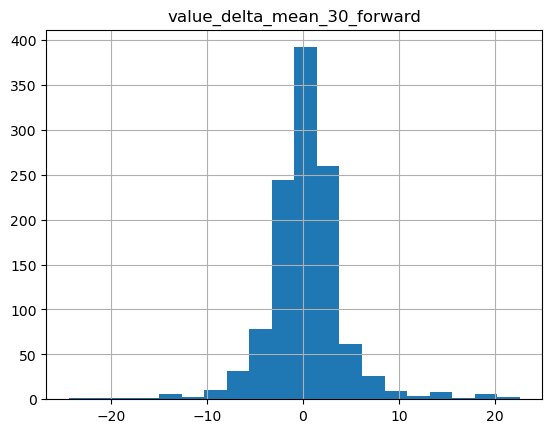

In [292]:
df_mset[(df_mset[outcome]>-25) & (df_mset[outcome]<25)].hist(outcome, bins=20)

In [302]:
def define_traffic_light_bounds(df, bounds):
    
    query = "df['traffic_light'] = "
    
    for i, boundary in enumerate(bounds):
        query = query + f"np.where(df['pred'] < {boundary}, {i}, \n"
    
    query = query + f"{i+1}{(i+1)*')'}"
    
    print(query)
    
    exec(query)
    
define_traffic_light_bounds(df, [-8, -5, 0, 5, 8])

df['traffic_light'] = np.where(df['pred'] < -8, 0, 
np.where(df['pred'] < -5, 1, 
np.where(df['pred'] < 0, 2, 
np.where(df['pred'] < 5, 3, 
np.where(df['pred'] < 8, 4, 
5)))))


In [303]:
df['traffic_light'].value_counts().sort_values()

0     2
4     4
1     7
2    36
3    47
Name: traffic_light, dtype: int64

In [300]:
df['traffic_light'].value_counts().sort_values()

0     1
4     4
1     8
2    36
3    47
Name: traffic_light, dtype: int64

array([[<Axes: title={'center': 'pred'}>]], dtype=object)

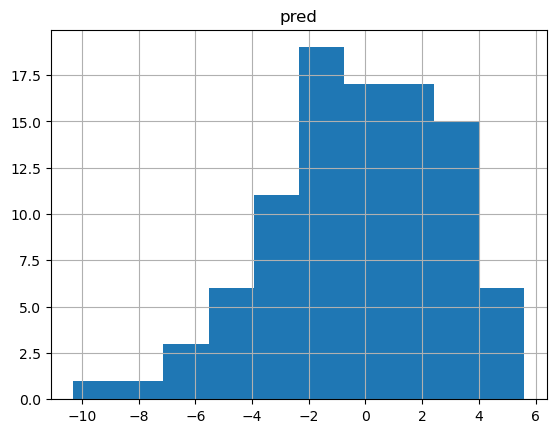

In [287]:
df.hist('pred')

In [248]:
outcome = 'value_delta_mean_30_forward'
correlation_vars = feat_vars + [outcome]

df_corr = df_mset[correlation_vars].corr().reset_index().rename(columns={'index':'feat'})
df_corr[df_corr.feat != outcome][[outcome]].sort_values(outcome)

value_delta_mean_30_forward
187                    -0.170384
194                    -0.159619
188                    -0.126528
104                    -0.120598
38                     -0.112639
..                           ...
76                      0.145933
75                      0.168959
191                     0.177965
178                     0.218930
192                     0.233669

[227 rows x 1 columns]

In [223]:
df_monthly_corrs = pd.concat(correlations)
df_monthly_corrs.sort_values('value_delta_mean_30_forward')

feat  \
0     unfixed_net_prop_total_calls_pct_change_4week   
0    unfixed_net_prop_total_calls_pct_change_12week   
0   unfixed_net_prop_calls_month_6_pct_change_2week   
0   unfixed_purchase_calls_month_1_pct_change_8week   
1   unfixed_purchase_calls_month_1_pct_change_4week   
..                                              ...   
4                    unfixed_net_prop_calls_month_2   
4              unfixed_net_prop_total_calls_season1   
5                      unfixed_net_prop_total_calls   
5                    unfixed_net_prop_calls_month_1   
5                      unfixed_net_prop_total_calls   

    value_delta_mean_30_forward  null_prop  report_month  
0                     -0.722734   0.777778            11  
0                     -0.590039   0.700935             3  
0                     -0.537697   0.098039             7  
0                     -0.521684   0.520833             9  
1                     -0.517773   0.500000             9  
..                          ...        ...           ...  
4                      0.705550   0.000000             1  
4                      0.744451   0.000000            10  
5                      0.760458   0.421569             8  
5                      0.792102   0.000000             1  
5                      0.865368   0.475248            10  

[72 rows x 4 columns]

In [210]:
df = df_mset[df_mset.report_month==9]
df.isnull().sum().sort_values()

date                                                      0
unfixed_purchase_total_calls_season2_pct_change_1week     0
unfixed_purchase_total_calls_season2_pct_change_2week     0
unfixed_purchase_total_calls_season2_pct_change_4week     0
unfixed_purchase_total_calls_season2_pct_change_8week     0
                                                         ..
unfixed_purchase_calls_month_1_pct_change_4week          48
unfixed_net_calls_month_1_pct_change_1week               48
unfixed_purchase_calls_month_1_pct_change_2week          49
unfixed_purchase_calls_month_1_pct_change_8week          50
unfixed_purchase_calls_month_1_pct_change_1week          52
Length: 179, dtype: int64

<Axes: xlabel='unfixed_net_prop_calls_month_2', ylabel='value_delta_mean_30_forward'>

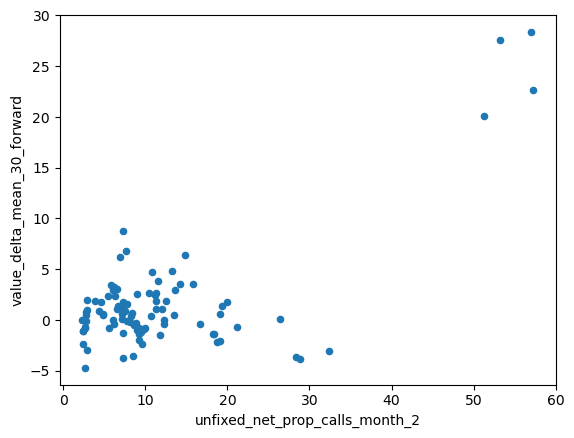

In [227]:
df_mset[df_mset.report_month==1].plot(kind='scatter', x='unfixed_net_prop_calls_month_2', y='value_delta_mean_30_forward')

/Users/thomaspile/anaconda3/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='unfixed_net_prop_total_calls', ylabel='value_delta_mean_30_forward'>

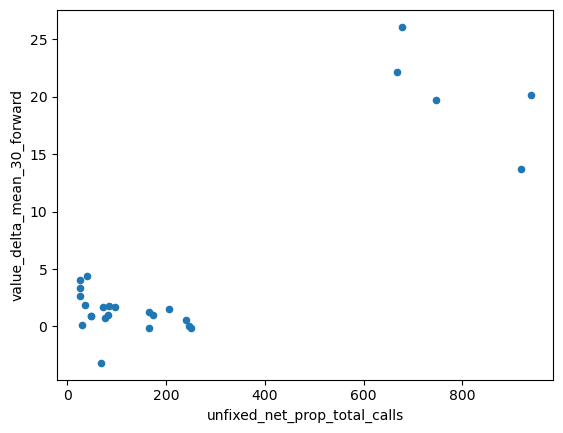

In [217]:
df_mset[df_mset.report_month==10].plot(kind='scatter', x='unfixed_net_prop_total_calls', y='value_delta_mean_30_forward')

<Axes: xlabel='unfixed_sale_total_calls_pct_change_12week', ylabel='value_delta_mean_30_forward'>

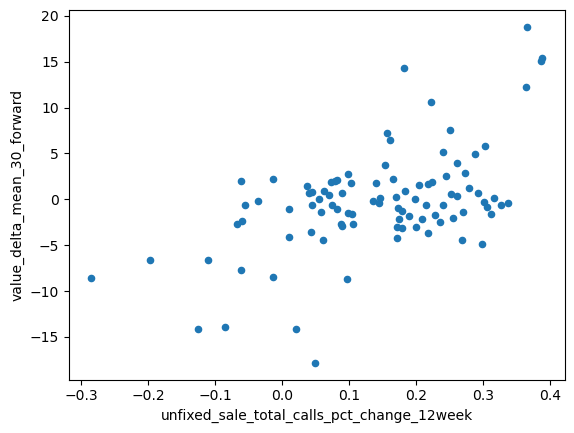

In [207]:
df_mset[df_mset.report_month==9].plot(kind='scatter', x='unfixed_sale_total_calls_pct_change_12week', y='value_delta_mean_30_forward')

In [96]:
df_binary

month                                          feature      corr    pvalue
0       2  unfixed_purchase_calls_month_2_pct_change_4week  0.072163  0.016875
1       3  unfixed_purchase_calls_month_2_pct_change_4week  0.072163  0.016875
2       4  unfixed_purchase_calls_month_2_pct_change_4week  0.072163  0.016875
3       5  unfixed_purchase_calls_month_2_pct_change_4week  0.072163  0.016875
4       6  unfixed_purchase_calls_month_2_pct_change_4week  0.072163  0.016875
5       7  unfixed_purchase_calls_month_2_pct_change_4week  0.072163  0.016875
6       8  unfixed_purchase_calls_month_2_pct_change_4week  0.072163  0.016875
7       9  unfixed_purchase_calls_month_2_pct_change_4week  0.072163  0.016875
8      10  unfixed_purchase_calls_month_2_pct_change_4week  0.072163  0.016875
9      11  unfixed_purchase_calls_month_2_pct_change_4week  0.072163  0.016875
10     12  unfixed_purchase_calls_month_2_pct_change_4week  0.072163  0.016875
11      1  unfixed_purchase_calls_month_2_pct_change_4week  0.072163  0.016875

<Axes: xlabel='unfixed_purchase_calls_month_2', ylabel='pct_delta_mean_30_forward'>

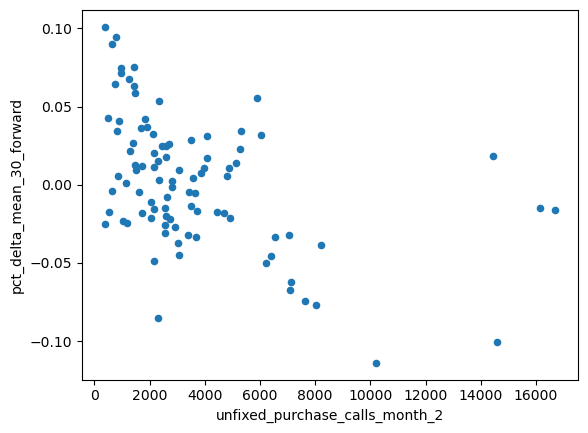

In [59]:
prep.df_mset[prep.df_mset.report_month == 2].plot(x='unfixed_purchase_calls_month_2', y='pct_delta_mean_30_forward', kind='scatter')

/Users/thomaspile/anaconda3/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='unfixed_purchase_calls_month_2', ylabel='pct_delta_mean_30_forward'>

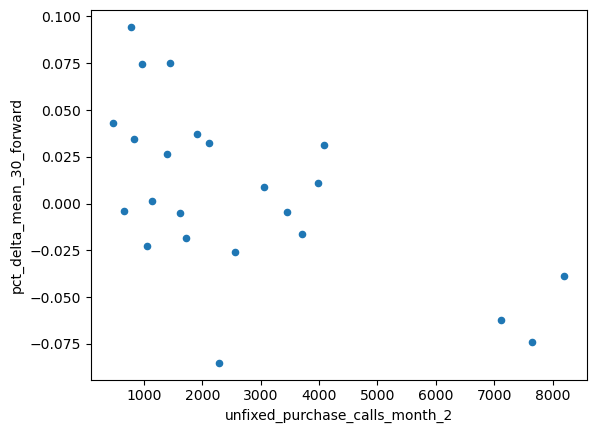

In [122]:
prep.df_mset[prep.df_mset.report_week == 6].plot(x='unfixed_purchase_calls_month_2', y='pct_delta_mean_30_forward', kind='scatter')